In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

**Exercice 1.**

Consider 2D heat transfer across the domain shown in the figure below. Solve the heat transfer problem, with the following boundary conditions:

• The external part of the boundary is convecting to 25°C with a heat transfer coefficient of 350 W/(m$^2$°C).

In the domain use the following material property:

• The thermal conductivity:

$$
k(x,y)=\begin{cases}
k_0 = 9.6 W/m·°C, & \quad \text{ in } W_0 ,\\
k_1 = 400. W/m·°C, & \quad \text{ in }  W_1 \cup W_2),
\end{cases}
$$

and the load:

$$ f(x, y) = \begin{cases}
0.0, & \quad \text{ in }  W_0,\\
99, & W_1 \cup W_2.
\end{cases}$$

* Plot the subdomains and the approximate solution to the solution!

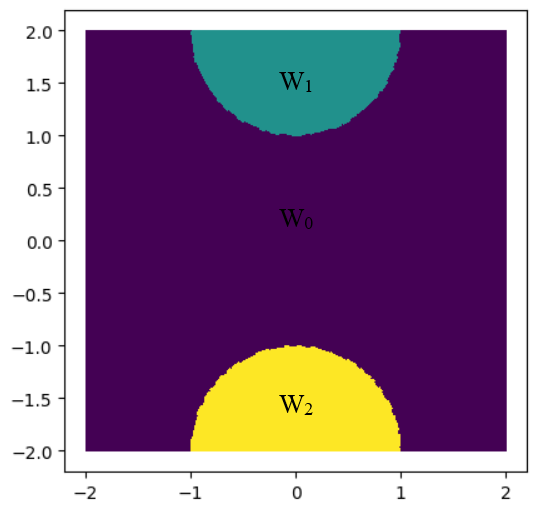

dim(Vh) =  4010


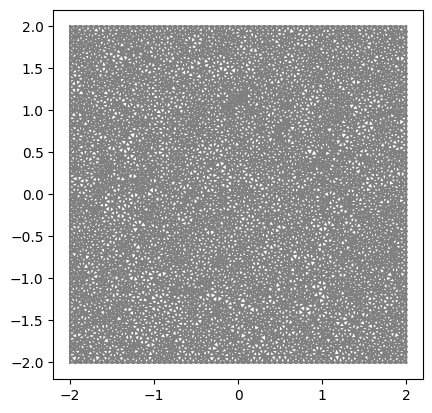

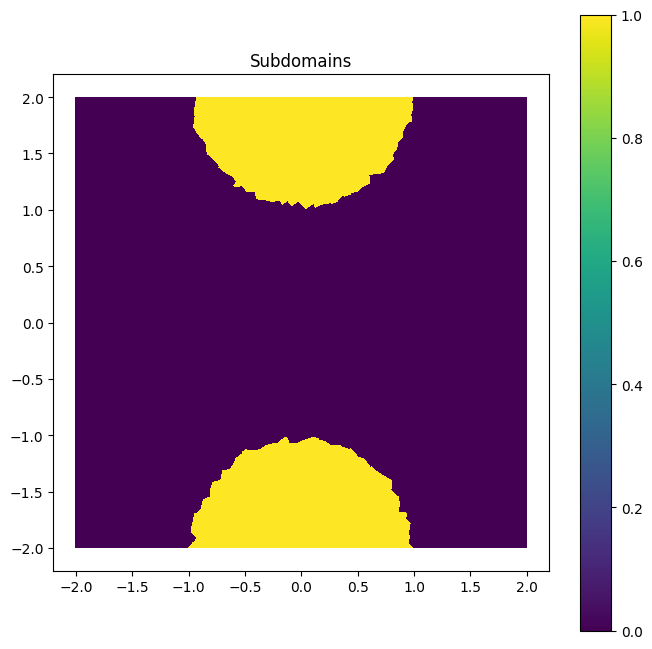

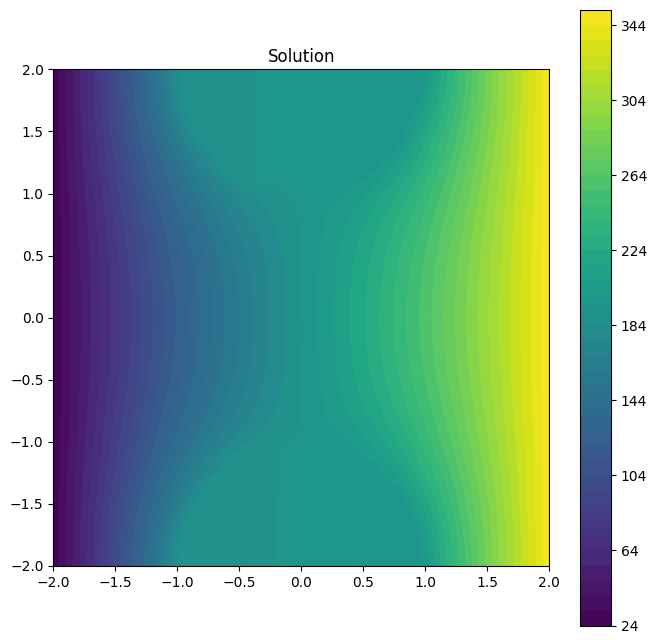

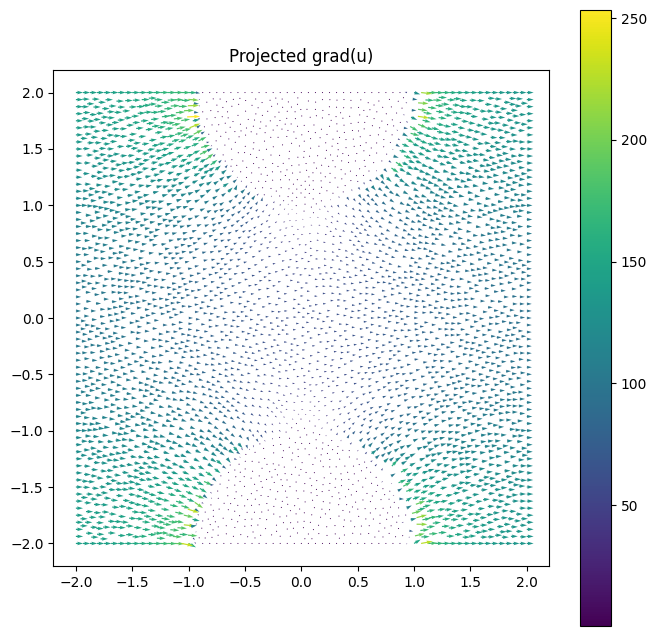

In [5]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

A = Point(-2, -2)
B = Point(2, 2)

domain = Rectangle(A, B)

circ_rad = 1
circ1 = Circle(Point(2.0, 0.0),circ_rad) # top circle
circ2 = Circle(Point(-2.0, 0.0),circ_rad) # top circle

# Make subdomain from mesh elements

domain.set_subdomain(1, circ1)
domain.set_subdomain(2, circ2)

# Generate Mesh
mesh = generate_mesh(domain, 50)
plot(mesh)
#
d = 1
Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())

# Define input data
k0 = Constant(9.60)
k1 = Constant(400)
g_B = Constant(0.0)
g_T = Constant(0.0)
T_L = Constant(25.0)
T_R = Constant(350.0)
f   = Constant(0.0)
f1   = Constant(99.0)

#
#  Define Dirichlet boundary condition
#
def Left(x, on_boundary):
  return on_boundary and near(x[0] , -2)

bc_1 = DirichletBC(Vh, T_L, Left)
#
def Right(x, on_boundary):
  return on_boundary and near(x[0] , 2)

bc_2 = DirichletBC(Vh, T_R, Right)
#
bcs = [bc_1, bc_2]

#
# Define subdomains labels
#
class Top_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] - 0)**2 + (x[1] - 2)**2)
    return (r < circ_rad * 1.0001)

class Bottom_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +0)**2 + (x[1] + 2)**2)
    return (r < circ_rad * 1.0001)
#
# Initialize sub-domain instances
top_hole = Top_hole()
bottom_hole = Bottom_hole()
#
# Define subdomains
subdomain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# mark the entire subdomains as 0
subdomain_markers.set_all(0)
#
# Mark the subdomains  1
top_hole.mark(subdomain_markers, 1)
bottom_hole.mark(subdomain_markers , 1)

# Plot subdomains
plt.figure(figsize=(8,8))
c = plot(subdomain_markers, title="Subdomains")
plt.colorbar(c)

#
# Define boundary labels
#
class Bottom(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], -2.0)

class Top(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], 2.0)

# Initialize sub-domain instances
top = Top()
bottom = Bottom()
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0
boundaries.set_all(0)
#
# Mark the boundaries 2 and 3
top.mark(boundaries, 2)
bottom.mark(boundaries, 3)

# Define the integration on boundaries and subdomains
#
dx=Measure('dx', domain=mesh, subdomain_data=subdomain_markers)
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational form
u = TrialFunction(Vh)
v = TestFunction(Vh)

a = inner(k0*grad(u), grad(v))*dx(0) + inner(k1*grad(u), grad(v))*dx(1)
L = f*v*dx(0) + f1*v*dx(1) + g_T*v*ds(2) + g_B*v*ds(3)

# Solve problem
u = Function(Vh)
solve(a == L, u, bcs)

# Plot solution
plt.figure(figsize=(8,8))
c = plot(u, title="Solution")
plt.colorbar(c)

plt.figure(figsize=(8,8))
p = plot(grad(u), title="Projected grad(u)")
plt.colorbar(p)